 # Table of Contents
<div class="toc" style="margin-top: 1em;"><ul class="toc-item" id="toc-level0"><li><span><a href="http://localhost:8889/notebooks/BackRiverFlowFiles.ipynb#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="http://localhost:8889/notebooks/BackRiverFlowFiles.ipynb#Output-FileName" data-toc-modified-id="Output-FileName-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Output FileName</a></span></li><li><span><a href="http://localhost:8889/notebooks/BackRiverFlowFiles.ipynb#Historical-Data" data-toc-modified-id="Historical-Data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Historical Data</a></span></li><li><span><a href="http://localhost:8889/notebooks/BackRiverFlowFiles.ipynb#Realtime-Data" data-toc-modified-id="Realtime-Data-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Realtime Data</a></span></li><li><span><a href="http://localhost:8889/notebooks/BackRiverFlowFiles.ipynb#Concatenate-Historical-and-Real" data-toc-modified-id="Concatenate-Historical-and-Real-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Concatenate Historical and Real</a></span></li></ul></div>

Process Hydrographic Canada downloaded files to produce river files

# Imports #

In [19]:
import datetime
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

# Output FileName #

In [20]:
filename = 'Roberts_Roberts_flow'

# Historical Data #

In [21]:
data = pd.read_csv('hydro_files/daily_20221203T0345_Roberts.csv', skiprows=1)
data = data[data.PARAM == 1]
data = data.set_index('Date')
data = data.drop([' ID', 'PARAM'], axis=1)
data[-5:]

,Value,SYM
Date,,
2021/12/27,0.746,E
2021/12/28,0.766,E
2021/12/29,0.683,E
2021/12/30,0.618,E
2021/12/31,0.383,E


In [22]:
year, month, day = [], [], []
for i, index in enumerate(data.index):
    year.append(index[0:4])
    month.append(index[5:7])
    day.append(index[8:10])

In [23]:
outdata = pd.DataFrame({'year': year, 
                        'month':month, 
                        'day': day,
                        'discharge': data.Value, 
                        'comment': data.SYM}, columns=['year', 'month', 'day', 
                                                       'discharge', 'comment'])

In [24]:
outdata[-5:]

,year,month,day,discharge,comment
Date,,,,,
2021/12/27,2021,12,27,0.746,E
2021/12/28,2021,12,28,0.766,E
2021/12/29,2021,12,29,0.683,E
2021/12/30,2021,12,30,0.618,E
2021/12/31,2021,12,31,0.383,E


# From Virginia at Hydrographic Service

,Value
Date (PST),
2021-01-01,11.367644
2021-01-02,10.143490
2021-01-03,11.075872
2021-01-04,11.264658
2021-01-05,12.278073
...,...
2021-12-27,1.296929
2021-12-28,1.105082
2021-12-29,0.984177


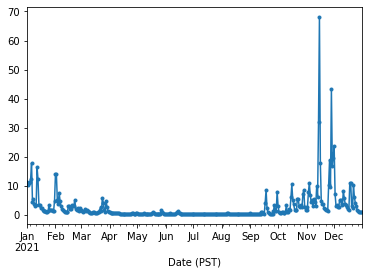

In [7]:
vdata = pd.read_csv('hydro_files/Discharge.Working_08MH155.20210101.csv', skiprows=14)
vdata['Date (PST)'] = pd.to_datetime(vdata['Timestamp (UTC-08:00)'])
vdata = vdata.resample('d', on='Date (PST)').mean().dropna(how='all')
vdata = vdata.drop(['Grade', 'Qualifiers'], axis=1)
vdata['Value'].plot(marker='.');
vdata

In [8]:
voutdata = pd.DataFrame({'year': vdata.index.year, 
                        'month': vdata.index.month, 
                        'day': vdata.index.day,
                        'discharge': vdata['Value']}, columns=['year', 'month', 'day', 
                                                       'discharge'])

# Realtime Data #

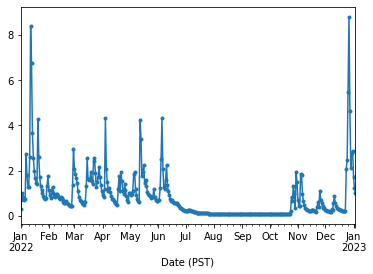

In [26]:
rtdata = pd.read_csv('hydro_files/08GA047_QR_20230103T1857.csv', skiprows=9)
rtdata['Date (PST)'] = pd.to_datetime(rtdata['Date (PST)'])
rtdata.set_index('Date (PST)')
rtdata = rtdata.resample('d', on='Date (PST)').mean().dropna(how='all')
rtdata = rtdata.drop(['Parameter '], axis=1)
rtdata['Value (m³/s)'].plot(marker='.');

In [27]:
rtoutdata = pd.DataFrame({'year': rtdata.index.year, 
                        'month': rtdata.index.month, 
                        'day': rtdata.index.day,
                        'discharge': rtdata['Value (m³/s)']}, columns=['year', 'month', 'day', 
                                                       'discharge'])

# Concatenate Historical, Virginia and Realtime #
# or just Historical and Realtime #

In [28]:
#result = pd.concat([outdata, voutdata, rtoutdata])
result = pd.concat([outdata, rtoutdata])
result = result[~result.index.duplicated(keep='first')]
result

,year,month,day,discharge,comment
1959/04/28,1959,04,28,1.250000,NaN
1959/04/29,1959,04,29,5.660000,NaN
1959/04/30,1959,04,30,3.680000,NaN
1959/05/01,1959,05,01,5.890000,NaN
1959/05/02,1959,05,02,1.250000,NaN
...,...,...,...,...,...
2022-12-30 00:00:00,2022,12,30,2.784931,NaN
2022-12-31 00:00:00,2022,12,31,2.885000,NaN
2023-01-01 00:00:00,2023,1,1,1.696840,NaN
2023-01-02 00:00:00,2023,1,2,1.213368,NaN


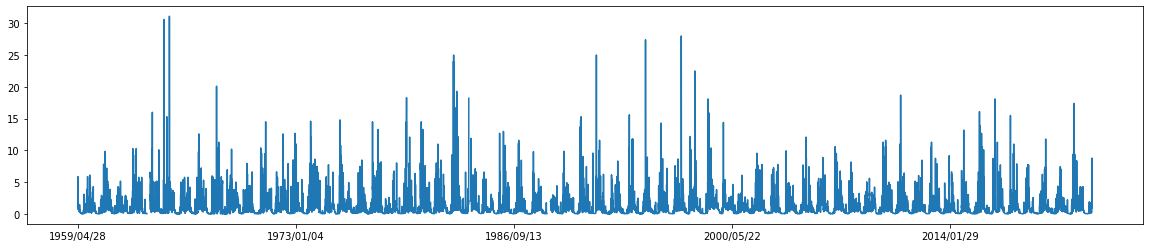

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(20, 4))
result['discharge'].plot(ax=ax);

In [30]:
result.to_csv(path_or_buf=filename, sep=' ', 
               columns=['year', 'month', 'day', 'discharge'], 
               header=False, index=False, float_format="%.6E")


## Check

In [31]:
alltogether = pd.read_csv(filename, header=None, index_col=False, sep=' ', 
                          names=['Year', 'Month', 'Day', 'Flow'])

In [32]:
alltogether.index = pd.to_datetime(alltogether.drop(['Flow'], axis=1))

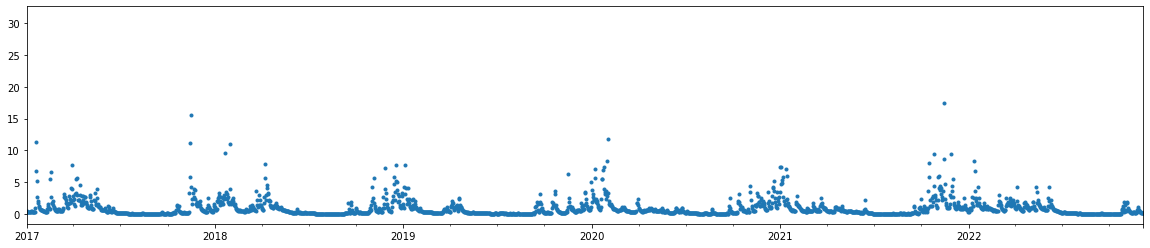

In [33]:
alltogether.Flow.plot(figsize=(20,4), xlim=(datetime.date(2017, 1, 1), datetime.date(2022, 12, 5)), 
                      linewidth=0, marker='.');

## Theodosia Checks

In [89]:
diversion = pd.read_csv('river_flows/Theodosia_Diversion_flow', header=None, index_col=False, sep=' ', 
                          names=['Year', 'Month', 'Day', 'Flow'])
diversion.index = pd.to_datetime(diversion.drop(['Flow'], axis=1))

In [90]:
bypass = pd.read_csv('river_flows/Theodosia_Bypass_flow', header=None, index_col=False, sep=' ', 
                          names=['Year', 'Month', 'Day', 'Flow'])
bypass.index = pd.to_datetime(bypass.drop(['Flow'], axis=1))

In [92]:
scotty = pd.read_csv('river_flows/Theodosia_Scotty_flow', header=None, index_col=False, sep=' ', 
                          names=['Year', 'Month', 'Day', 'Flow'])
scotty.index = pd.to_datetime(scotty.drop(['Flow'], axis=1))

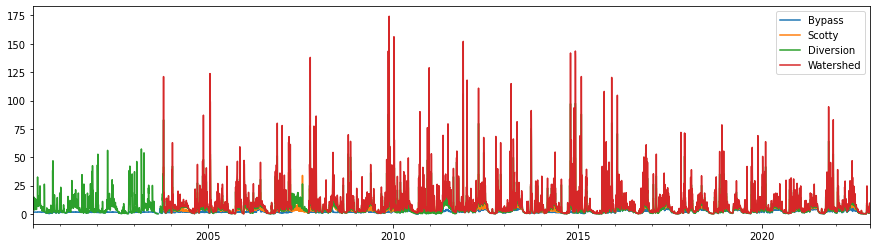

In [93]:
bypass.Flow.plot(figsize=(15,4), label='Bypass')
scotty.Flow.plot(figsize=(15,4), label='Scotty')
diversion.Flow.plot(label='Diversion')
(diversion.Flow + scotty.Flow - bypass.Flow).plot(label='Watershed')
plt.legend()

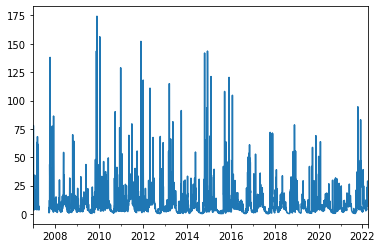

In [94]:
(diversion.Flow + scotty.Flow - bypass.Flow).plot(
    xlim=(datetime.date(2007, 1, 1), datetime.date(2022, 4, 5)));

In [96]:
(diversion.Flow + scotty.Flow - bypass.Flow).min()

0.09700000000000009

In [138]:
Squamish = pd.read_csv('river_flows/Squamish_Brackendale_flow', header=None, index_col=False, sep=' ', 
                          names=['Year', 'Month', 'Day', 'Flow'])
Squamish.index = pd.to_datetime(Squamish.drop(['Flow'], axis=1))

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/pandas/util/_decorators.py:311: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  return func(*args, **kwargs)


In [142]:
SquamishO = pd.read_csv('river_flows/Squamish_Brackendale_medium', header=None, index_col=False, sep=' ', 
                          names=['Year', 'Month', 'Day', 'Flow'])
SquamishO.index = pd.to_datetime(SquamishO.drop(['Flow'], axis=1))

<AxesSubplot:>

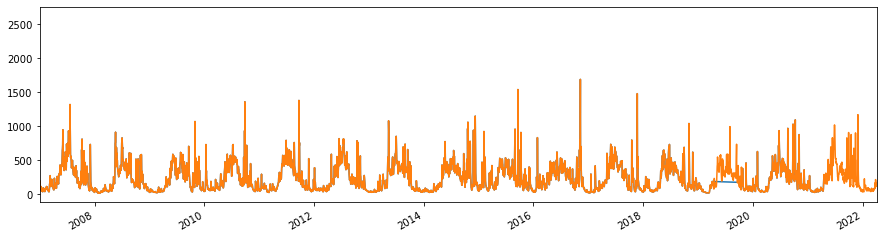

In [144]:
SquamishO.Flow.plot(figsize=(15,4), label='Mine', xlim=(datetime.date(2007, 1, 1), datetime.date(2022, 4, 5)))
Squamish.Flow.plot(figsize=(15,4), label='Dougs', xlim=(datetime.date(2007, 1, 1), datetime.date(2022, 4, 5)))

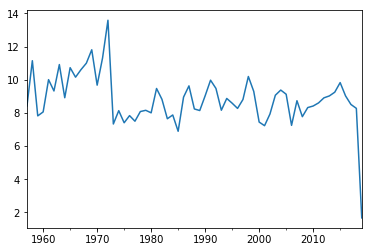

In [337]:
(Bute.Flow*86400*365/1e9).plot()

In [340]:
(Bute.Flow*86400*365/1e9)[:-1].mean()

8.937704975408858

In [341]:
Bute.Flow[:-1].mean()

283.4127655824727